## Combining the RL algorithm with the CNN

In [19]:
import torch
import torch.nn as nn
import pickle
import pandas as pd
from models_and_training_functions import DeblurCNN, train_model, visualise_training
from Richardson_lucy_functions import richardson_lucy, gaussian_kernel_1D
import matplotlib.pyplot as plt

In [20]:
# Loading the CNN written and trained in CNN_NN.ipynb

# loading the trained model
model = DeblurCNN()
model = torch.load('deblur_cnn_model_complete.pth')
model.eval() 



C:\Users\Jpjha\AppData\Local\Temp\ipykernel_33788\3619525821.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('deblur_cnn_model_complete.pth')


DeblurCNN(
  (encoder): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(64, 1, kernel_size=(7,), stride=(1,), padding=(3,))
  )
)

In [32]:
# Loading a sample of testing data

filepath = "C:\\Users\\Jpjha\\OneDrive\\Desktop\\Decon by ML\\Code\\CNN_test_data.pkl"
test_data = pd.read_pickle(filepath)


In [33]:
def prepare_testing_data(validation_data):

    blur_cols = [col for col in validation_data.columns if 'y_blur' in col]
    clean_cols = [col for col in validation_data.columns if 'y_clean' in col]

    blur_cols.sort(key=lambda x: int(x.split('_')[-1]))
    clean_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    # Extract the actual DATA from these columns (not just the names)
    blur_data = validation_data[blur_cols].values.T  # Transpose so each row is a signal
    clean_data = validation_data[clean_cols].values.T
    
    # Convert to tensors
    blur_tensors = torch.FloatTensor(blur_data)
    clean_tensors = torch.FloatTensor(clean_data)

    return blur_tensors, clean_tensors

The firt method attempted involves passing each RL iteration's estimate through the model before running another iteration. 

As expected this caused the estimate to worsen as the number of iterations increased. 

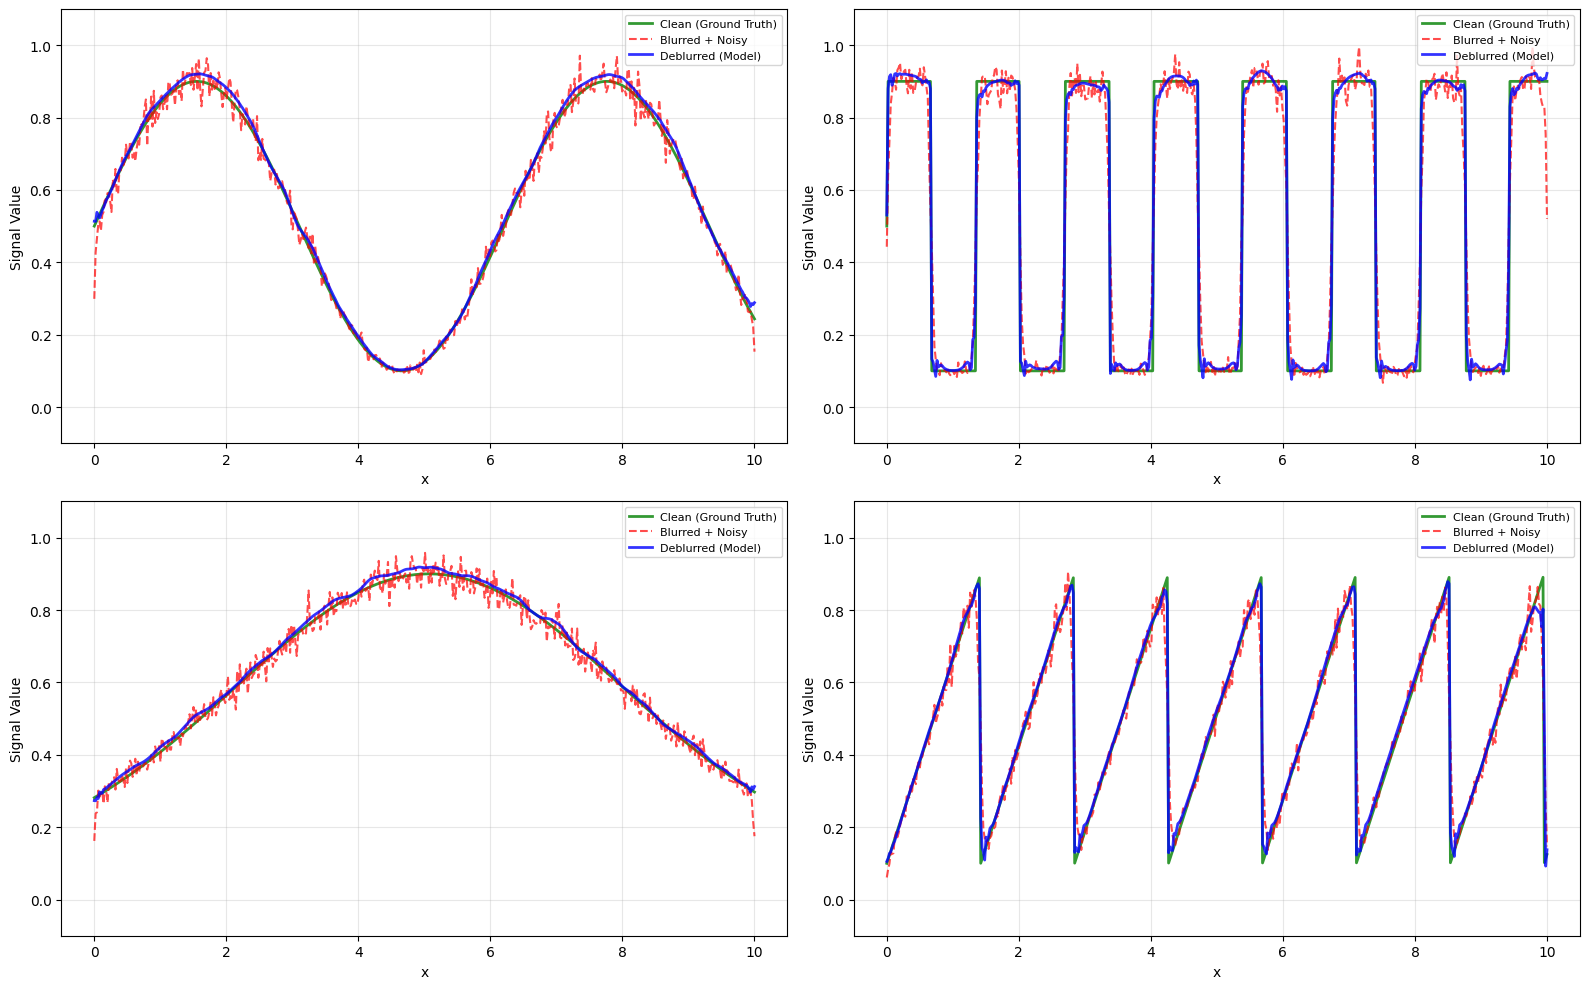

In [52]:
kernel = gaussian_kernel_1D(size=15, sigma=2.0)
blur_tensors, clean_tensors = prepare_testing_data(test_data)
measured_signal = blur_tensors
numb_iterations = 1

# Process each signal individually
results = []

for idx in range(len(blur_tensors)):  # Loop through each signal in the batch
    signal = blur_tensors[idx].unsqueeze(0)  # Get one signal: [1, 500]
    
    for i in range(numb_iterations):
        # Apply Richardson-Lucy to single signal
        RL_deblur = richardson_lucy(signal.numpy(), kernel, num_its=1)  # [1, 500]
        
        # Apply CNN model
        model_deblur = model(torch.FloatTensor(RL_deblur))  # [1, 500]
        
        # Update signal for next iteration
        signal = model_deblur.detach()
    
    results.append(signal)

# Stack results back together
blur_tensors = torch.cat(results, dim=0)  # [16, 500]


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
    
for i in range(4):
    ax = axes[i]
    
    # Plot all three signals
    ax.plot(test_data['x'], clean_tensors[i], 'g-', label='Clean (Ground Truth)', 
            linewidth=2, alpha=0.8)
    ax.plot(test_data['x'], measured_signal[i], 'r--', label='Blurred + Noisy', 
            linewidth=1.5, alpha=0.7)
    ax.plot(test_data['x'], blur_tensors[i], 'b-', label='Deblurred (Model)', 
            linewidth=2, alpha=0.8)
    
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('Signal Value', fontsize=10)
    ax.set_ylim([-0.1, 1.1])
    #ax.set_title(f'Validation Signal {i+1} (MSE: {mse_values[i]:.6f})', fontsize=11)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()
    




The second method tested was to implement the RL algorithm inside rthe forward function of the model. 


